# Nuisance Correction
## Evaluation of White Matter PCs for Nuisance Regression
### 4/3/17 Deliverable

Goal: Determine if the nuisance correction method of removing the first five principal components of the white matter from the fMRI data is statistically supported.

To do this, an F-test was performed in order to determine a p-value that represents how well the white matter model fits the data. The HCP dataset was utilized for twenty subjects performing the emotion and motor tasks described [here](http://www.humanconnectome.org/documentation/Q1/task-fMRI-protocol-details.html).

### Why an F-test?

An F-test of overall significance in regression "compares the fits of different linear models." This test as we apply it compares the model from the white matter components to an "intercept-only model,... a regression model that contains no predictors." The null hypothesis is therefore that the white matter model and intercept-only model are equal with the alternative hypothesis being that the fit of the intercept-only model is "significantly reduced" compared to the white matter model. Thus if we obtain a p-value lower than the significance level we will specify as 0.05, then we reject the null hypothesis and conclude that the white matter model provides a better fit than the intercept-only model, which means the white matter model "predicts the response variable better than the mean of the response." [More info](http://blog.minitab.com/blog/adventures-in-statistics-2/what-is-the-f-test-of-overall-significance-in-regression-analysis)

### Description

We first calculate the beta values of the GLM of the white matter components. The GLM system of equations can be described as: $$y = Xb + e$$ where $X$ is the design matrix, $b$ is the beta value vector, and $e$ is the added error vector. The values predicted by the model are $\hat{y} = Xb$. We then calculate the sum of squares for the model as $SSM = \sum_{i=1}^n (\hat{y_i}-\bar{y})^2$ and the sum of squares for error as $SSE = \sum_{i=1}^n (y_i-\hat{y_i})^2$. We calculate an $F$ statistic with $DFM = p-1$ degrees of freedom in the numerator and $DFE = n-p$ degrees of freedom in the denominator where $n$ is the number of timesteps and $p$ is the number of regressors. The $F$ statistic is then calculated as follows: $$F_{DFM,DFE} = \frac{SSM \times DFE}{SSE \times DFM}$$ From here, we can use the value of the $F$ statistic and the degrees of freedom to calculate the p-value. A high F-value corresponds to a low p-value.

### Implementation

After running the datasets through the pipeline in order to obtain the registered fMRI images, the following shell script was utilized in order to perform the F-tests on each of the subjects' task data.

In [ ]:
#!/bin/bash
# analysis.sh
#$1 = reg_fmri
#$2 = reg_struct

exec 4<$1
exec 5<$2

while read -r reg_fmri <&4 && read -r reg_struct<&5; do
    python analysis.py $reg_fmri $reg_struct
done 4<$1 5<$2

The script calls analysis.py which is as follows:

In [ ]:
from ndmg.utils import utils as mgu
import nibabel as nb
import numpy as np
import scipy.signal as signal
import scipy.stats as stats
import sys
fmri = sys.argv[1]
amri = sys.argv[2]
amask = '../../FNGS_server/atlases/mask/MNI152_T1-2mm_brain_mask.nii.gz'
gmask = '../avg152T1_gray_bin.nii'
an = 1
outdir = './'
lvmask = '../../FNGS_server/atlases/mask/HarvOx_lv_thr25-2mm.nii.gz'
amask_im = nb.load(amask)
amm = amask_im.get_data()
gmask_im = nb.load(gmask)
gmm = gmask_im.get_data()
lv_im = nb.load(lvmask)
lvm = lv_im.get_data()
fmri_name = mgu().get_filename(fmri)
anat_name = mgu().get_filename(amri)
nuisname = "".join([anat_name, "_nuis"])
map_path = mgu().name_tmps(outdir, nuisname, "_map")
cmd1 = " ".join(["fast -t", str(int(an)), "-n 3 -o", map_path, amri])
mgu().execute_cmd(cmd1)
wm_prob = map_path + "_pve_2.nii.gz"
prob = nb.load(wm_prob)
prob_dat = prob.get_data()
mask = (prob_dat > .99).astype(int)
for i in range(0, 2):
    erode_mask = np.zeros(mask.shape)
    x, y, z = np.where(mask != 0)
    if (x.shape == y.shape and y.shape == z.shape):
        for j in range(0, x.shape[0]):
            md = mask.shape
            if (mask[x[j],y[j],z[j]] and
                mask[np.min((x[j]+1, md[0]-1)),y[j],z[j]] and
                mask[x[j],np.min((y[j]+1, md[1]-1)),z[j]] and
                mask[x[j],y[j],np.min((z[j]+1, md[2]-1))] and
                mask[np.max((x[j]-1, 0)),y[j],z[j]] and
                mask[x[j],np.max((y[j]-1, 0)),z[j]] and
                mask[x[j],y[j],np.max((z[j]-1, 0))]):
                erode_mask[x[j],y[j],z[j]] = 1
    else:
        raise ValueError('Your mask erosion has an invalid shape.')
    mask = erode_mask

wmm = mask
mask = gmm
for i in range(0, 1):
    erode_mask = np.zeros(mask.shape)
    x, y, z = np.where(mask != 0)
    if (x.shape == y.shape and y.shape == z.shape):
        for j in range(0, x.shape[0]):
            md = mask.shape
            if (mask[x[j],y[j],z[j]] and
                mask[np.min((x[j]+1, md[0]-1)),y[j],z[j]] and
                mask[x[j],np.min((y[j]+1, md[1]-1)),z[j]] and
                mask[x[j],y[j],np.min((z[j]+1, md[2]-1))] and
                mask[np.max((x[j]-1, 0)),y[j],z[j]] and
                mask[x[j],np.max((y[j]-1, 0)),z[j]] and
                mask[x[j],y[j],np.max((z[j]-1, 0))]):
                erode_mask[x[j],y[j],z[j]] = 1
    else:
        raise ValueError('Your mask erosion has an invalid shape.')
    mask = erode_mask

gmm = mask
fmri_im = nb.load(fmri)
amri_im = nb.load(amri)
fmri_dat = fmri_im.get_data()
voxel = fmri_dat[fmri_dat.sum(axis=3) > 0, :].T
wm_ts = fmri_dat[wmm != 0, :].T
lv_ts = fmri_dat[lvm != 0, :].T
t = voxel.shape[0]
lin_reg = np.array(range(0, t))
quad_reg = np.array(range(0, t))**2
csf_reg = lv_ts.mean(axis=1)
wm_ts = wm_ts[:, wm_ts.std(axis=0) != 0]
wm_ts = signal.detrend(wm_ts, axis=0, type='linear')
wm_ts = wm_ts - wm_ts.mean(axis=0)
wm_ts = np.divide(wm_ts, wm_ts.std(axis=0))
U, s, V = np.linalg.svd(wm_ts)
wm_reg = U[:, 0:5]
R = np.column_stack((np.ones(t), lin_reg, quad_reg, wm_reg, csf_reg))
coefs = np.linalg.inv(R.T.dot(R)).dot(R.T).dot(voxel)
yhat = R.dot(coefs)
res = voxel - yhat
ssm = np.sum((yhat-voxel.mean(0))**2, axis=0)
sse = np.sum(res**2, axis=0)
dfm = coefs.shape[0]-1
dfe = voxel.shape[0]-coefs.shape[0]
msm = ssm/dfm
mse = sse/dfe
f = msm/mse
f_brain = np.zeros(fmri_dat.shape[:3])
f_brain[fmri_dat.sum(axis=3) > 0] = f.T
img = nb.Nifti1Image(f_brain, header=fmri_im.header, affine=fmri_im.affine)
nb.save(img, fmri[11:17] + '_fvals.nii.gz')
p = 1 - stats.f.cdf(f_brain[f_brain != 0], dfm, dfe)
p_white = 1 - stats.f.cdf(f_brain[(f_brain != 0) & (wmm != 0)], dfm, dfe)
p_grey = 1 - stats.f.cdf(f_brain[(f_brain != 0) & (gmm != 0)], dfm, dfe)
p_other = 1 - stats.f.cdf(f_brain[(f_brain != 0) & (wmm != 0) & (gmm !=0)], dfm, dfe)
fi = open('pvals_all.txt', 'a+')
for val in p.flat:
    fi.write(repr(val) + '\n')

fi.close()
fi = open('pwhite_all.txt', 'a+')
fm = open('pwhite_mean.txt', 'a+')
fp = open('pwhite_' + fmri[11:17] + '.txt', 'w')
for val in p_white.flat:
    fi.write(repr(val) + '\n')
    fp.write(repr(val) + '\n')

fm.write(repr(np.mean(p_white)) + '\n')
fi.close()
fm.close()
fp.close()
fi = open('pgrey_all.txt', 'a+')
fm = open('pgrey_mean.txt', 'a+')
fp = open('pgrey_' + fmri[11:17] + '.txt', 'w')
for val in p_grey.flat:
    fi.write(repr(val) + '\n')
    fp.write(repr(val) + '\n')

fm.write(repr(np.mean(p_grey)) + '\n')
fi.close()
fm.close()
fp.close()
fi = open('pother_all.txt', 'a+')
fm = open('pother_mean.txt', 'a+')
fp = open('pother_' + fmri[11:17] + '.txt', 'w')
for val in p_other.flat:
    fi.write(repr(val) + '\n')
    fp.write(repr(val) + '\n')

fm.write(repr(np.mean(p_other)) + '\n')
fi.close()
fm.close()
fp.close()

### Simulation

We show a basic simulation below to prove the validity of our method. The first simulation shows a 2x2x2 "brain" with 100 timesteps where the voxel values for the fMRI and white matter are independently randomly chosen. In this simulation we expect little correlation between the timeseries and therefore the p-values should be rather high with little to none below the 0.05 threshold. The second simulation shows a 2x2x2 "brain" with 100 timesteps where the voxel values for the fMRI and white matter are set as the same randomly chosen values. In this simulation we expect total correlation between the timeseries and therefore the p-values should all be below our threshold. As we can see, our simulated results are as expected.

[ 0.10880807  0.48019167  0.28623981  0.79338569  0.81082436  0.86541309
  0.20617917  0.85899707]


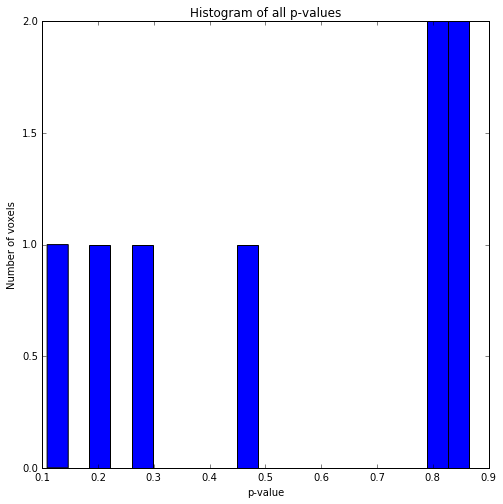

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import scipy.stats as stats
fmri_dat = np.random.rand(2,2,2,100)
wm = np.random.rand(2,2,2,100)
voxel = fmri_dat[fmri_dat.sum(axis=3) > 0, :].T
wm_ts = wm.T
t = voxel.shape[0]
lin_reg = np.array(range(0, t))
quad_reg = np.array(range(0, t))**2
wm_ts = wm_ts[:, wm_ts.std(axis=0) != 0]
wm_ts = signal.detrend(wm_ts, axis=0, type='linear')
wm_ts = wm_ts - wm_ts.mean(axis=0)
wm_ts = np.divide(wm_ts, wm_ts.std(axis=0))
U, s, V = np.linalg.svd(wm_ts)
wm_reg = U[:, 0:5]
R = np.column_stack((np.ones(t), lin_reg, quad_reg, wm_reg))
coefs = np.linalg.inv(R.T.dot(R)).dot(R.T).dot(voxel)
yhat = R.dot(coefs)
res = voxel - yhat
ssm = np.sum((yhat-voxel.mean(0))**2, axis=0)
sse = np.sum(res**2, axis=0)
dfm = coefs.shape[0]-1
dfe = voxel.shape[0]-coefs.shape[0]
msm = ssm/dfm
mse = sse/dfe
f = msm/mse
f_brain = np.zeros(fmri_dat.shape[:3])
f_brain[fmri_dat.sum(axis=3) > 0] = f.T
p = 1 - stats.f.cdf(f_brain[f_brain != 0], dfm, dfe)
print p
plt.figure(0, figsize=(8,8))
plt.hist(p, 20)
plt.title('Histogram of all p-values')
plt.xlabel('p-value')
plt.ylabel('Number of voxels');

[  1.11022302e-16   1.11022302e-16   1.11022302e-16   1.11022302e-16
   1.11022302e-16   1.11022302e-16   1.11022302e-16   1.11022302e-16]


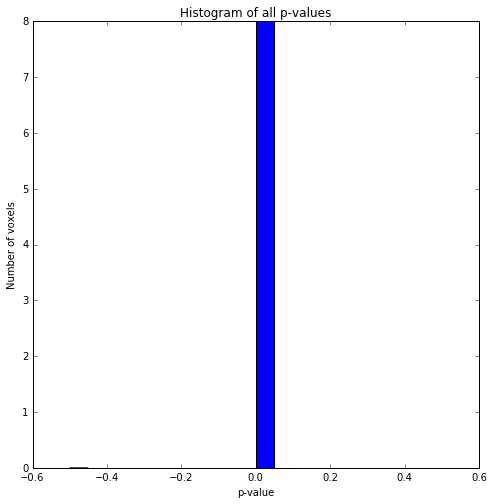

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import scipy.stats as stats
fmri_dat = np.random.rand(2,2,2,100)
voxel = fmri_dat[fmri_dat.sum(axis=3) > 0, :].T
wm_ts = voxel
t = voxel.shape[0]
lin_reg = np.array(range(0, t))
quad_reg = np.array(range(0, t))**2
wm_ts = wm_ts[:, wm_ts.std(axis=0) != 0]
wm_ts = signal.detrend(wm_ts, axis=0, type='linear')
wm_ts = wm_ts - wm_ts.mean(axis=0)
wm_ts = np.divide(wm_ts, wm_ts.std(axis=0))
U, s, V = np.linalg.svd(wm_ts)
wm_reg = U[:, 0:5]
R = np.column_stack((np.ones(t), lin_reg, quad_reg, wm_reg))
coefs = np.linalg.inv(R.T.dot(R)).dot(R.T).dot(voxel)
yhat = R.dot(coefs)
res = voxel - yhat
ssm = np.sum((yhat-voxel.mean(0))**2, axis=0)
sse = np.sum(res**2, axis=0)
dfm = coefs.shape[0]-1
dfe = voxel.shape[0]-coefs.shape[0]
msm = ssm/dfm
mse = sse/dfe
f = msm/mse
f_brain = np.zeros(fmri_dat.shape[:3])
f_brain[fmri_dat.sum(axis=3) > 0] = f.T
p = 1 - stats.f.cdf(f_brain[f_brain != 0], dfm, dfe)
print p
plt.figure(0, figsize=(8,8))
plt.hist(p, 20)
plt.title('Histogram of all p-values')
plt.xlabel('p-value')
plt.ylabel('Number of voxels');

### Results

For the emotion task, we obtain the following histograms for the p values:  

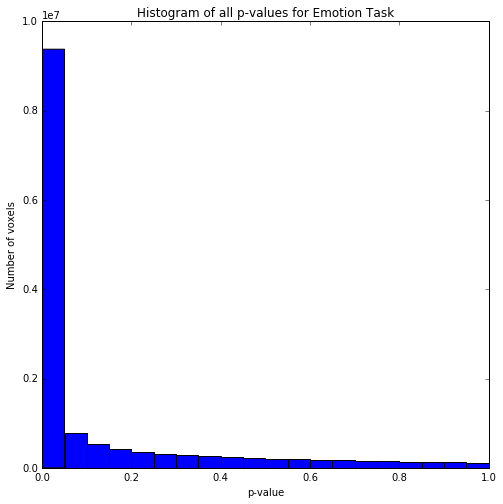

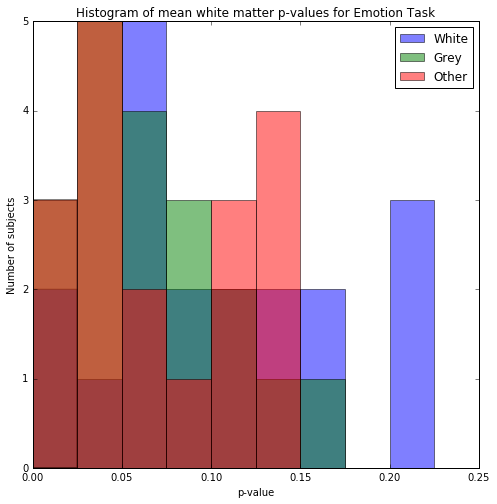

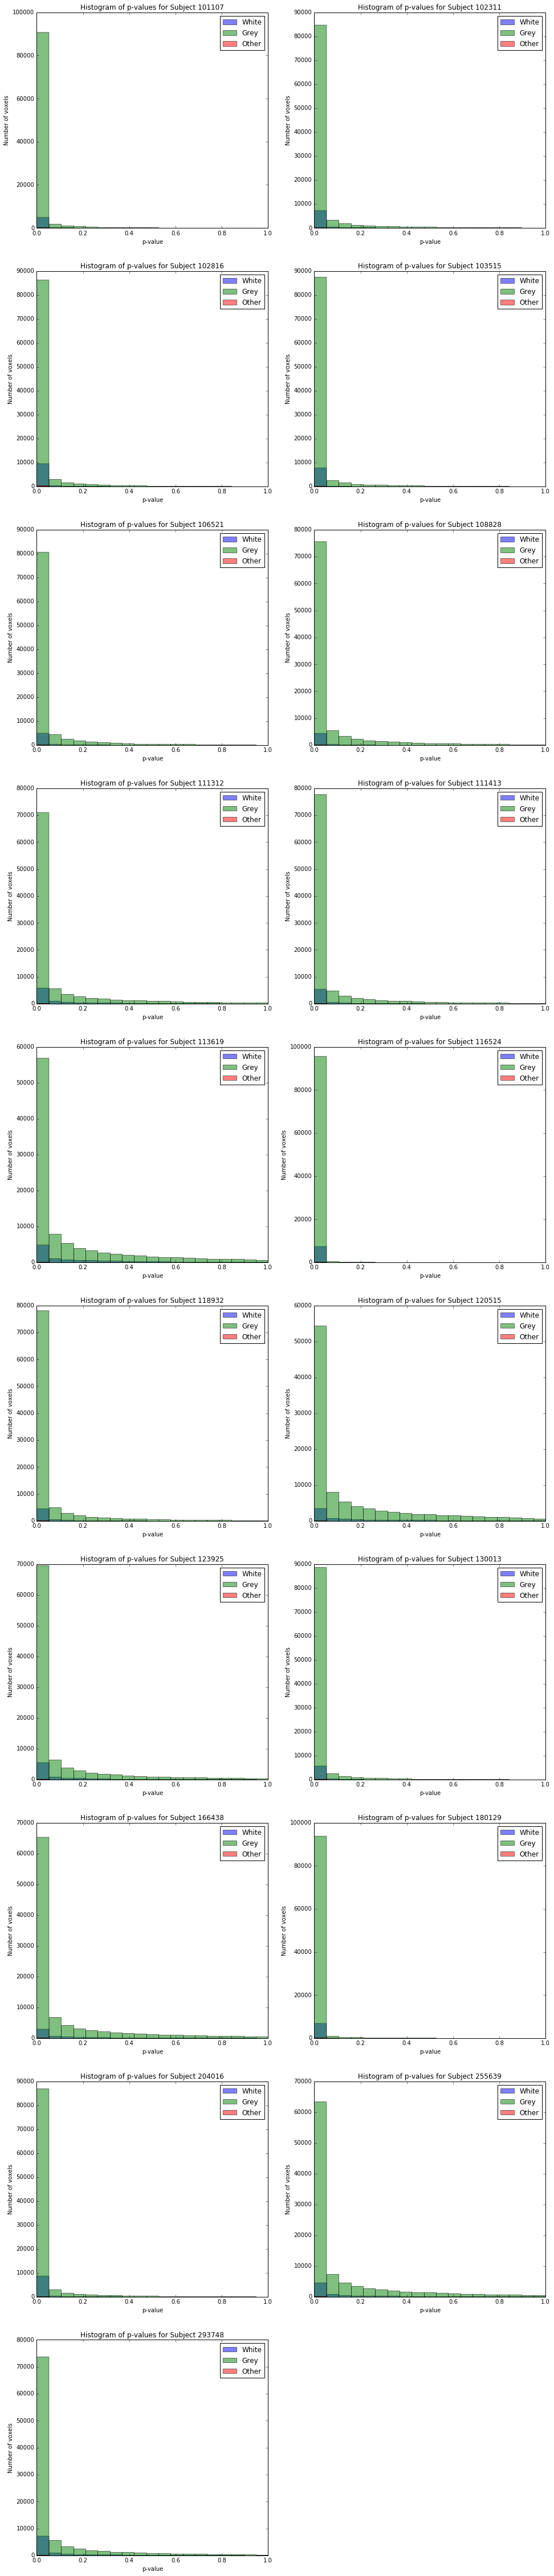

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
with open('./emotion/pvals_all.txt') as f:
    pvals = f.readlines()
pvals = [float(x.strip()) for x in pvals]
plt.figure(0, figsize=(8,8))
plt.hist(pvals, 20)
plt.title('Histogram of all p-values for Emotion Task')
plt.xlabel('p-value')
plt.ylabel('Number of voxels');
with open('./emotion/pwhite_mean.txt') as f:
    pwmean = f.readlines()
pwmean = [float(x.strip()) for x in pwmean]
with open('./emotion/pgrey_mean.txt') as f:
    pgmean = f.readlines()
pgmean = [float(x.strip()) for x in pgmean]
with open('./emotion/pother_mean.txt') as f:
    pomean = f.readlines()
pomean = [float(x.strip()) for x in pomean]
plt.figure(1, figsize=(8,8))
bins = np.linspace(0, 0.225, 10)
plt.hist(pwmean, bins, alpha=0.5, label='White')
plt.hist(pgmean, bins, alpha=0.5, label='Grey')
plt.hist(pomean, bins, alpha=0.5, label='Other')
plt.legend(loc='upper right')
plt.title('Histogram of mean white matter p-values for Emotion Task')
plt.xlabel('p-value')
plt.ylabel('Number of subjects');
subjects = ['101107', '102311', '102816', '103515', '106521', '108828', '111312', '111413', '113619', '116524', \
            '118932', '120515', '123925', '130013', '166438', '180129', '204016', '255639', '293748']
plt.figure(2, figsize=(16,80))
for i in range(len(subjects)):
    with open('./emotion/pwhite_' + subjects[i] + '.txt') as f:
        pw = f.readlines()
    pw = [float(x.strip()) for x in pw]
    with open('./emotion/pgrey_' + subjects[i] + '.txt') as f:
        pg = f.readlines()
    pg = [float(x.strip()) for x in pg]
    with open('./emotion/pother_' + subjects[i] + '.txt') as f:
        po = f.readlines()
    po = [float(x.strip()) for x in po]
    plt.subplot(len(subjects)/2+1, 2, i+1)
    bins = np.linspace(0, 1, 20)
    plt.hist(pw, bins, alpha=0.5, label='White')
    plt.hist(pg, bins, alpha=0.5, label='Grey')
    plt.hist(po, bins, alpha=0.5, label='Other')
    plt.legend(loc='upper right')
    title = 'Histogram of p-values for Subject ' + subjects[i]
    plt.title(title)
    plt.xlabel('p-value')
    plt.ylabel('Number of voxels');

By saving the F values as a nifti image, we can view them as a brain. Here is an example of Subject 101107's F values viewed as a brain:

![Emotion](./emotion_fvals.png)

For the motor task, we obtain the following histograms for the p values:  

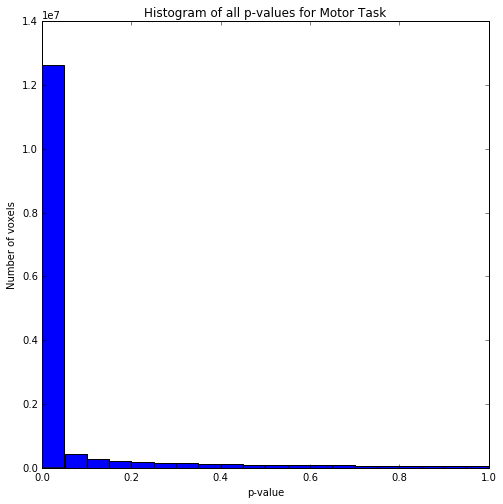

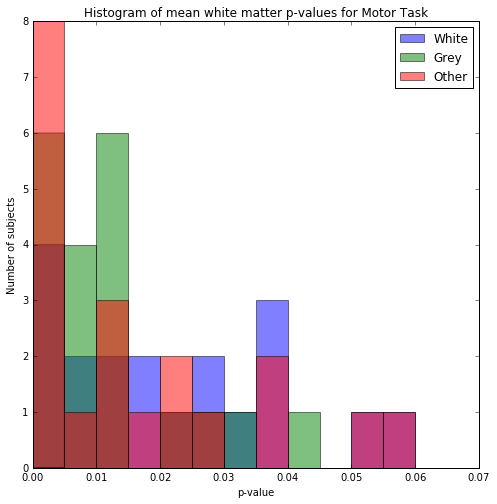

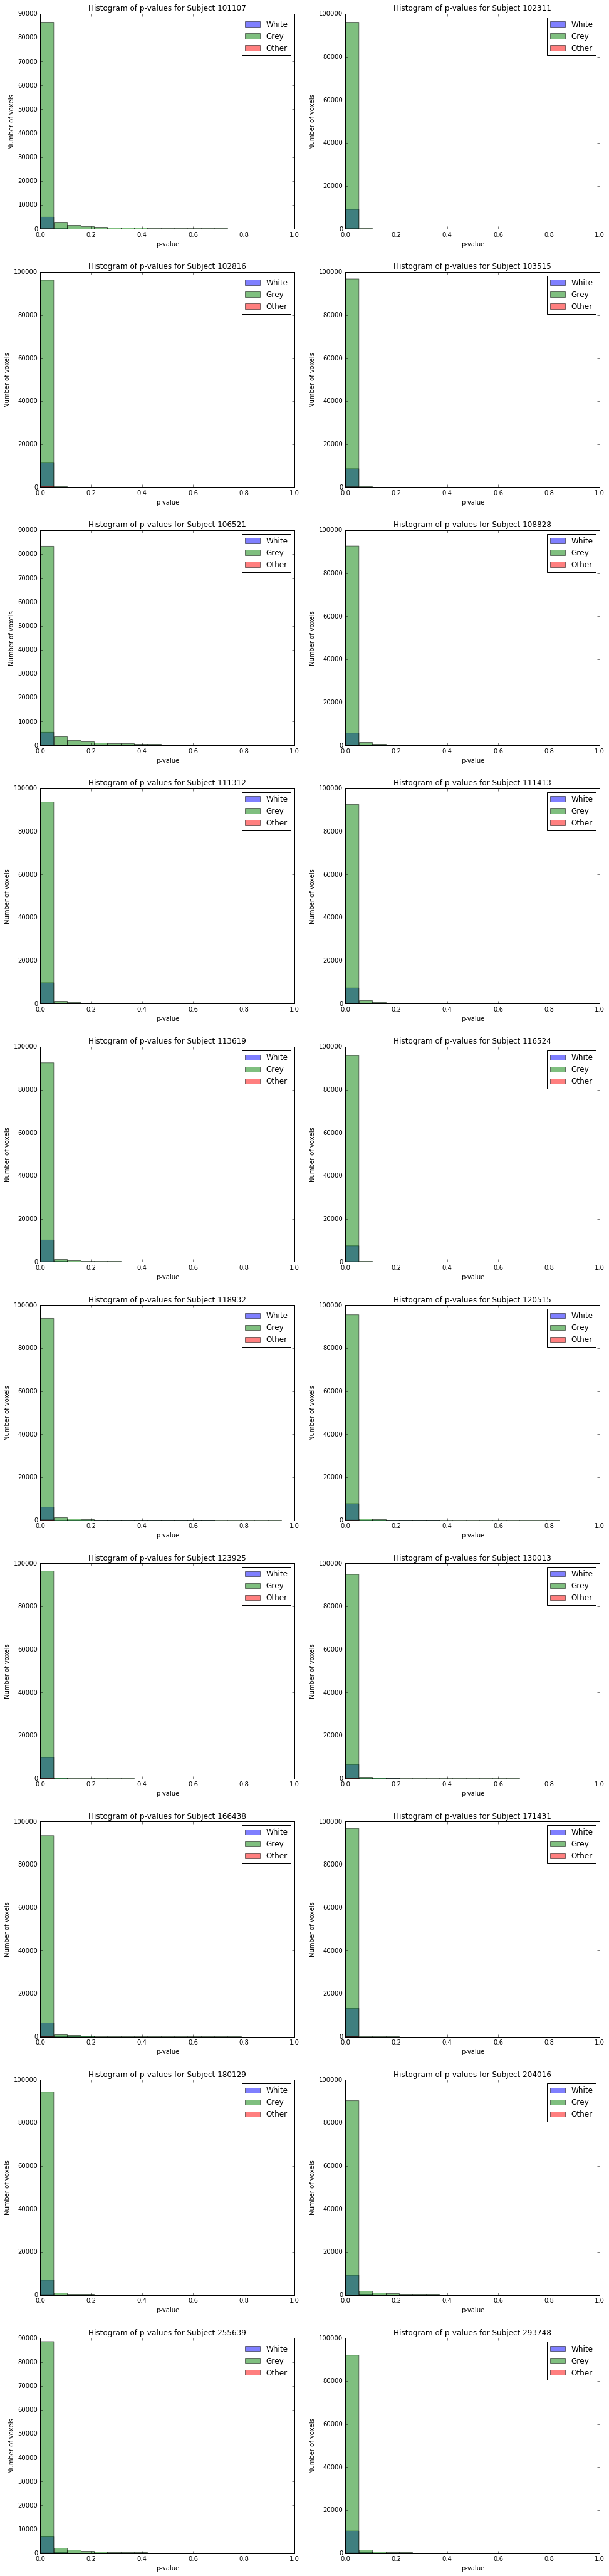

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
with open('./motor/pvals_all.txt') as f:
    pvals = f.readlines()
pvals = [float(x.strip()) for x in pvals]
plt.figure(0, figsize=(8,8))
plt.hist(pvals, 20)
plt.title('Histogram of all p-values for Motor Task')
plt.xlabel('p-value')
plt.ylabel('Number of voxels');
with open('./motor/pwhite_mean.txt') as f:
    pwmean = f.readlines()
pwmean = [float(x.strip()) for x in pwmean]
with open('./motor/pgrey_mean.txt') as f:
    pgmean = f.readlines()
pgmean = [float(x.strip()) for x in pgmean]
with open('./motor/pother_mean.txt') as f:
    pomean = f.readlines()
pomean = [float(x.strip()) for x in pomean]
plt.figure(1, figsize=(8,8))
bins = np.linspace(0, 0.06, 13)
plt.hist(pwmean, bins, alpha=0.5, label='White')
plt.hist(pgmean, bins, alpha=0.5, label='Grey')
plt.hist(pomean, bins, alpha=0.5, label='Other')
plt.legend(loc='upper right')
plt.title('Histogram of mean white matter p-values for Motor Task')
plt.xlabel('p-value')
plt.ylabel('Number of subjects');
subjects = ['101107', '102311', '102816', '103515', '106521', '108828', '111312', '111413', '113619', '116524', \
            '118932', '120515', '123925', '130013', '166438', '171431', '180129', '204016', '255639', '293748']
plt.figure(2, figsize=(16,80))
for i in range(len(subjects)):
    with open('./motor/pwhite_' + subjects[i] + '.txt') as f:
        pw = f.readlines()
    pw = [float(x.strip()) for x in pw]
    with open('./motor/pgrey_' + subjects[i] + '.txt') as f:
        pg = f.readlines()
    pg = [float(x.strip()) for x in pg]
    with open('./motor/pother_' + subjects[i] + '.txt') as f:
        po = f.readlines()
    po = [float(x.strip()) for x in po]
    plt.subplot(len(subjects)/2+1, 2, i+1)
    bins = np.linspace(0, 1, 20)
    plt.hist(pw, bins, alpha=0.5, label='White')
    plt.hist(pg, bins, alpha=0.5, label='Grey')
    plt.hist(po, bins, alpha=0.5, label='Other')
    plt.legend(loc='upper right')
    title = 'Histogram of p-values for Subject ' + subjects[i]
    plt.title(title)
    plt.xlabel('p-value')
    plt.ylabel('Number of voxels');

Here is an example of Subject 101107's F values viewed as a brain:

![Motor](./motor_fvals.png)

### Discussion

While most of the mean p-values for the emotion task are above the specified significance of 0.05, when we look at the p-values voxelwise, the vast majority of the p-values are below the specified significance. For the motor task, both the majority of the mean p-values and the majority of the voxelwise p-values are below the specified significance. Since most values are below the significance, we should reject the null hypothesis in favor of the alternative hypothesis that the white matter model fits the data better than the intercept-only model. This suggests that many of the voxels in the data can be explained by white matter coefficients, which is problematic for the purposes of nuisance correction. However, some of the p-values were still above the significance, so using white matter principal components for nuisance correction could work acceptably in some cases.

### Discriminability

We further evaluated the emotion task to compare the discriminability of the white matter method and a high pass filtering method for nuisance correction. We calculated discriminability in two different ways: the first in which all six task blocks were treated as separate scans of the same subject and the second in which every task block was split into two and each block was treated as a separate subject with two scans. We see the results below for the white matter method followed by the high pass filtering method.

White Matter Six Blocks:
![White Matter Six Blocks](./hpf_six.jpeg)

White Matter Split Blocks:
![White Matter Split Blocks](./hpf_split.jpeg)

High Pass Filtering Six Blocks:
![HPF Six Blocks](./hpf_six.jpeg)

High Pass Filtering Split Blocks:
![HPF Split Blocks](./hpf_split.jpeg)